# Notebook 1 (LSTM): learning each model on different window sizes and then with 50 epochs 
Notebook contains LSTM models for predictions of weather in the next, second and third hour.
Window size describes how many previous timestamps to take for weather predictions. 
LSTM models are different - depends on which hour to predict.
At first each model is being tested on different window sizes. Then the models are being tested with 50 epochs of learning.

It is important to remember that timestamps are in distance of 30 minutes and the predictions are being made in next, second and third hour.

The models will be updating with new data in the next notebooks. There also bias will be calculated.

In the notebook MSE which means Mean Squared Error and MAE which means Mean Absolute Error is being used. 

#### MSE it is:
$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2
$$
Where:

- $ n $ is the number of data points.
- $ Y_i $ represents the actual value for the i-th data point.
- $ \hat{Y}_i $ represents the predicted value for the i-th data point.

#### MAE it is:
$$
MAE = \frac{1}{n} \sum_{i=1}^{n} |Y_i - \hat{Y}_i|
$$
Where:
- $ n $ is the number of data points.
- $ Y_i $ represents the actual value for the i-th data point.
- $ \hat{Y}_i $ represents the predicted value for the i-th data point.


## All necessary libraries imports

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.metrics import mean_absolute_error

Imports from helpful_functions.python script located in root/notebooks folder.

In [53]:
from helpful_functions import transform_data, LSTM_model1,LSTM_model2,LSTM_model3, make_predictions

## Files to load

In [54]:
# read the CSV files

# train data
train_data = pd.read_csv("all_data/data_for_main_model/data_ready_for_training.csv")
# models will be training on data from only 2013, 
# learning models on bigger data sizes without updates and reset states occurs to be useless
train_data = train_data[train_data['year'] == 2013]
train_data_step_half_hour = train_data[["relh", "skph", "temp"]]

# valid data - one future month
valid_data = pd.read_csv("all_data/data_for_main_model/data_ready_for_validation.csv")
valid_data =valid_data[(valid_data['year']==2014) & (valid_data['month']==1)]
valid_data_step_half_hour = valid_data[["relh", "skph", "temp"]]

# test data
test_data = pd.read_csv("all_data/data_for_main_model/data_ready_for_testing.csv")
test_data_step_half_hour = test_data[["relh", "skph", "temp"]]

# data frames for training process when distance between each timestamp equals one hour
# train
train_data_step_one_hour = train_data
train_data_step_one_hour['time'] = pd.to_datetime(train_data_step_one_hour['time'])
train_data_step_one_hour = train_data_step_one_hour[train_data_step_one_hour['time'].dt.minute == 0]
train_data_step_one_hour = train_data_step_one_hour[["relh", "skph", "temp"]]

train_data_step_half_hour = train_data_step_one_hour[["relh", "skph", "temp"]]

# valid
valid_data_step_one_hour = valid_data
valid_data_step_one_hour['time'] = pd.to_datetime(valid_data_step_one_hour['time'])
valid_data_step_one_hour = valid_data_step_one_hour[valid_data_step_one_hour['time'].dt.minute == 0]
valid_data_step_one_hour = valid_data_step_one_hour[["relh", "skph", "temp"]]

valid_data_step_half_hour = valid_data_step_one_hour[["relh", "skph", "temp"]]

# test
test_data_step_one_hour = test_data
test_data_step_one_hour['time'] = pd.to_datetime(test_data_step_one_hour['time'])
test_data_step_one_hour = test_data_step_one_hour[test_data_step_one_hour['time'].dt.minute == 0]
test_data_step_one_hour = test_data_step_one_hour[["relh", "skph", "temp"]]

test_data_step_half_hour = test_data_step_one_hour[["relh", "skph", "temp"]]

## Function for models learning and evaluation
MSE calculations for test set, loss learning values for training and validation sets and predictions for given window size and number of epochs.

In [55]:
def LSTMs_learning(window_size=12, epochs=10, step_one_hour=False):
    ## params:
    # window_size : number of timestamps to take for making predictions
    # epoch : number of epochs in training for models
    
    # lists for MSE for each model and weather variable
    MAE_humid = []
    MAE_wind = []
    MAE_temp = []

    # list to remember history of learning for each model
    history = []

    # list to remember each model
    all_models = []

    # MSE calculations for given actual and predicted values 
    # last_pred_hour == 3 means that predictions are from +1 hour till +3 hours
    last_pred_hour = 3

    if step_one_hour:
        # when step equals one hour
        hours_range = range(3)
        train_data = train_data_step_one_hour
        valid_data = valid_data_step_one_hour
        test_data = test_data_step_one_hour
    else:
        # when step equals half of hour
        hours_range = range(1,last_pred_hour*2,2)
        train_data = train_data_step_half_hour
        valid_data = valid_data_step_half_hour
        test_data = test_data_step_half_hour

    for hour in hours_range: # cause every data timestamp is in 30 min distance
        # hour : means how many timestamps are being taken for predictions
        # (hour == 1) it means that predictions will be made for next one hour
        # (hour == 3) it means that predictions will be made for second hour
        # (hour == 5) it means that predictions will be made for third hour

        # min and max values from test data calculations
        min = [np.min(train_data[m]) for m in train_data.columns]
        max = [np.max(train_data[m]) for m in train_data.columns]

        # division into explanatory X and response y variables
        X_train, y_train = transform_data(train_data,max,min,window_size, hour)
        # to be sure that data is of correct size
        len = y_train.shape[0]
        len = y_train.shape[0] - (y_train.shape[0] % (32))
        X_train = X_train[:len]
        y_train = y_train[:len]  

        X_val, y_val = transform_data(valid_data,max,min,window_size, hour)
        # to be sure that data is of correct size
        len = y_val.shape[0]
        len = y_val.shape[0] - (y_val.shape[0] % (32))
        X_val = X_val[:len]
        y_val = y_val[:len]  

        X_test, y_test = transform_data(test_data,max,min,window_size, hour)
        # to be sure that data is of correct size
        len = y_test.shape[0]
        len = y_test.shape[0] - (y_test.shape[0] % (32))
        X_test = X_test[:len]
        y_test = y_test[:len] 
        
        # log
        if step_one_hour:
            # when step equals one hour
            print(f"Start of the model training for predictions in {hour+1} hour.\n")
        else:
            # when step equals half of hour
            print(f"Start of the model training for predictions in {int((hour+1)/2)} hour.\n")

        # model training - model choosement depends on for which hour predictions are being made
        if step_one_hour:
            if(hour == 0):
                model, history_ = LSTM_model1(X_train, y_train, X_val, y_val, window_size = window_size, epochs = epochs)
            elif(hour == 1):
                model, history_ = LSTM_model2(X_train, y_train, X_val, y_val, window_size = window_size, epochs = epochs)
            else:
                model, history_ = LSTM_model3(X_train, y_train, X_val, y_val, window_size = window_size, epochs = epochs)
        else:
            if(hour == 1):
                model, history_ = LSTM_model1(X_train, y_train, X_val, y_val, window_size = window_size, epochs = epochs)
            elif(hour == 3):
                model, history_ = LSTM_model2(X_train, y_train, X_val, y_val, window_size = window_size, epochs = epochs)
            else:
                model, history_ = LSTM_model3(X_train, y_train, X_val, y_val, window_size = window_size, epochs = epochs)
        
        all_models.append(model)
        history.append(history_)

        # predictions
        pred, actual = make_predictions(model, X_test, y_test,  min, max)

        # append MAE for each hour
        MAE_humid.append(mean_absolute_error(actual[0], pred[0]))
        MAE_wind.append(mean_absolute_error(actual[1], pred[1]))
        MAE_temp.append(mean_absolute_error(actual[2], pred[2]))

    return MAE_humid, MAE_wind, MAE_temp,  pred, actual, history, all_models

Calculate and save minimum and maximum values to the csv file.

In [56]:
min = [np.min(train_data[m]) for m in train_data.columns]
max = [np.max(train_data[m]) for m in train_data.columns]

# make dataframe with min and max values
min_and_max = pd.DataFrame()
min_and_max['min'] = min
min_and_max['max'] = max

# save data to root/notebooks/generated_models/lstm_models folder
min_and_max.to_csv("generated_models/lstm_models/min_and_max")

# Comparison of learning each model on data where distance between timestamps equals one hour or half of hour

In [57]:
# learning models on data where distance between timestamps equals one hour
_, _, _, _, _, history_one, _ = LSTMs_learning(epochs = 10, window_size=6,step_one_hour=True)

# learning models on data where distance between timestamps equals half of hour
_, _, _, _, _, history_half, _ = LSTMs_learning(epochs = 10, window_size=12,step_one_hour=False)

Start of the model training for predictions in 1 hour.

Start of the model training for predictions in 2 hour.

Start of the model training for predictions in 3 hour.

Start of the model training for predictions in 1 hour.

Start of the model training for predictions in 2 hour.

Start of the model training for predictions in 3 hour.



Plots represent loss values of test and valid data sets for each epoch evaluated using MSE for different window sizes for predictions in the next, second and third hour.

In each subplot x-axis represents always the number of epoch and y-axis represents loss values of test and valid data sets evaluated using MSE.

It is important to know that this MSE errors are being evaluated for predictions which values are beetwen $ [0,1] $, beacuse of data normalization.

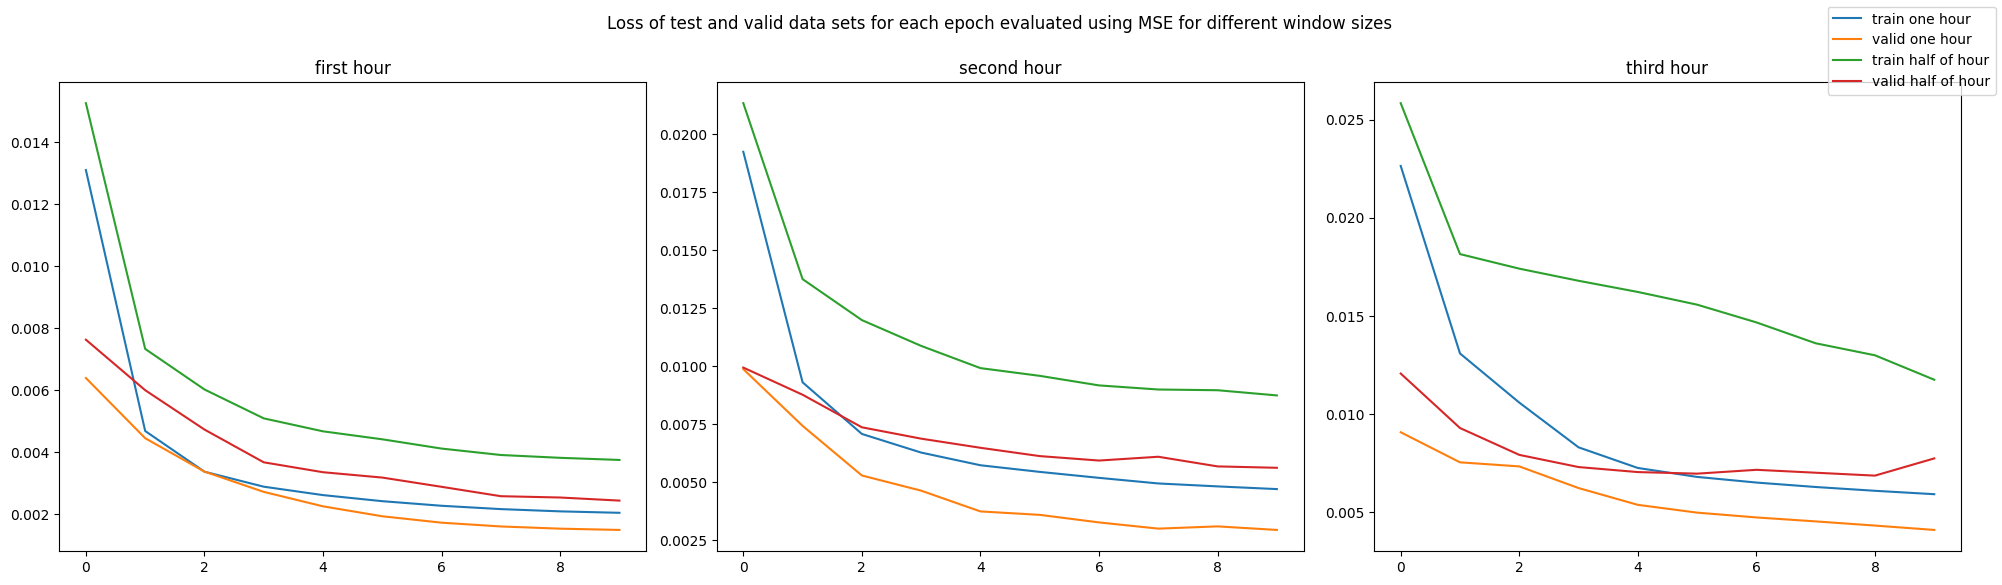

In [58]:
# figure init
fig, axs = plt.subplots(1,3, figsize=(20, 6))
fig.suptitle('Loss of test and valid data sets for each epoch evaluated using MSE for different window sizes')
fig.tight_layout(pad=2)

# addition of loss values to each subplot
# labels with numbers represents how many hours has been given for predictions as input for each model
axs[0].plot(history_one[0].history['loss'],  label='train one hour')
axs[0].plot(history_one[0].history['val_loss'],  label='valid one hour')
axs[0].plot(history_half[0].history['loss'],  label='train half of hour')
axs[0].plot(history_half[0].history['val_loss'],  label='valid half of hour')
axs[0].set_title('first hour')

axs[1].plot(history_one[1].history['loss'])
axs[1].plot(history_one[1].history['val_loss'])
axs[1].plot(history_half[1].history['loss'])
axs[1].plot(history_half[1].history['val_loss'])
axs[1].set_title('second hour')

axs[2].plot(history_one[2].history['loss'])
axs[2].plot(history_one[2].history['val_loss'])
axs[2].plot(history_half[2].history['loss'])
axs[2].plot(history_half[2].history['val_loss'])
axs[2].set_title('third hour')

fig.legend()

# Learning each model with 50 epochs

In [59]:
# learning models with 50 epochs and 12 of window size
MAE_humid, MAE_wind, MAE_temp, pred, actual, history, models = LSTMs_learning(epochs = 50, window_size=12) 

Start of the model training for predictions in 1 hour.

Start of the model training for predictions in 2 hour.

Start of the model training for predictions in 3 hour.



Plots represent loss values of test and valid data sets for each epoch evaluated using MSE for predictions in the next, second and third hour.

In each subplot x-axis represents always the number of epoch and y-axis represents loss values of test and valid data sets evaluated using MSE.

It is important to know that this MSE errors are being evaluated for predictions which values are beetwen $ [0,1] $, beacuse of data normalization.

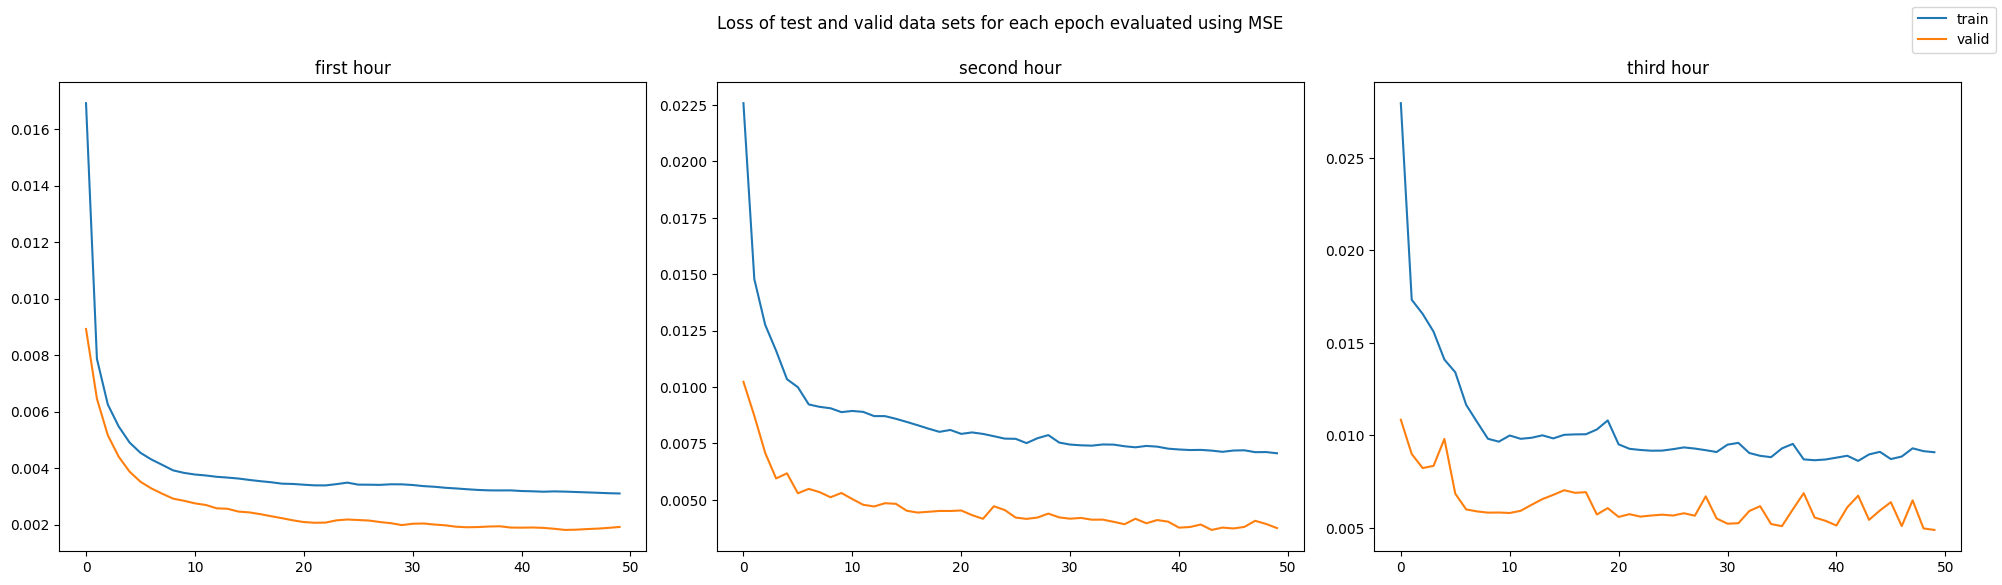

In [60]:
# figure init
fig, axs = plt.subplots(1,3, figsize=(20, 6))
fig.suptitle('Loss of test and valid data sets for each epoch evaluated using MSE')
fig.tight_layout(pad=2)

# addition of loss values to each subplot
axs[0].plot(history[0].history['loss'],  label='train')
axs[0].plot(history[0].history['val_loss'],  label='valid')
axs[0].set_title('first hour')

axs[1].plot(history[1].history['loss'])
axs[1].plot(history[1].history['val_loss'])
axs[1].set_title('second hour')

axs[2].plot(history[2].history['loss'])
axs[2].plot(history[2].history['val_loss'])
axs[2].set_title('third hour')

fig.legend()

MAE evaluated for each weather component separately after data denormalization.

Error is given:

- For temperature in °C.
- For relative humidity in %.
- For speed of wind in km/h.

In [61]:
MAE = pd.DataFrame()
MAE['hour'] = [1,2,3]
MAE['relh'] = MAE_humid
MAE['skph'] = MAE_wind
MAE['temp'] = MAE_temp

MAE

,hour,relh,skph,temp
0,1,6.488120,3.586023,1.588258
1,2,10.177022,4.349631,3.177544
2,3,13.169235,4.932963,4.345787


## Save every model for further update

In [62]:
for index in range(3):
    file_name = 'generated_models/lstm_models/' + 'lstm_' + str(index+1) + ".pkl"
    with open(file_name, "xb") as f_1:
        pickle.dump(models[index], f_1, -1)